In [21]:
import warnings 
import json
import gzip
import re
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

# NLP final project - rating prediction based on the amazon reviews

### The goal of this project is to create machine learning models that can predict if a review is a positive or negative review

## Load Data 

### Considering the training time, we will only use a the reviews for TV and movies to build our model

In [3]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [4]:
# Append reviews and ratings into 2 seperate lists
reviews = []
ratings = []
for review in parse('../Data/reviews_Movies_and_TV_5.json.gz'):
    reviews.append(review['reviewText'])
    ratings.append(review['overall'])

### Distribution of the ratings

Total Reviews:  1697533


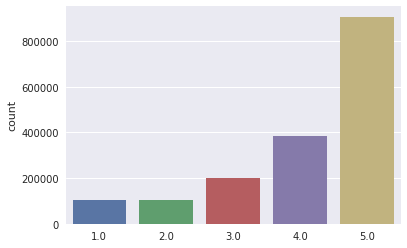

In [5]:
print('Total Reviews: ', len(reviews))
sns.countplot(ratings);

### Our purpose here is to determine whether the product has a positive rating or not.

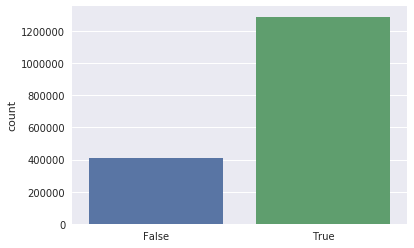

In [6]:
new_y = [rate >3 for rate in ratings]
sns.countplot(new_y);

### Class imbalanced can cause the model to biasly assigning a higher probility of being the majority class to each observation. To deal with this class imbalanced issue, we can compute the class weight for each class and then assign the minority class a heavier weight.

In [7]:
# computing the class weight
weights = compute_class_weight('balanced', np.unique(new_y), new_y)
# put them in to a dictionary
class_weights = {}
class_weights[0] = weights[0]
class_weights[1] = weights[1]
class_weights

{0: 2.0806619256688017, 1: 0.65816158783872858}

### Sample reviews

In [8]:
def remove_punctuation(string):
    return re.sub(r'[^\w\s]','',string.lower())

In [9]:
review_list = [remove_punctuation(review) for review in reviews]

In [10]:
print('First review: ', review_list[0], '---- with rating: ', ratings[0])
print('#'*110)
print('Second review: ', review_list[1], '---- with rating: ', ratings[1])
print('#'*110)
print('Third review: ', review_list[2], '---- with rating: ', ratings[2])

First review:  this is a charming version of the classic dickens tale  henry winkler makes a good showing as the scrooge character  even though you know what will happen this version has enough of a change to make it better that average  if you love a christmas carol in any version then you will love this ---- with rating:  4.0
##############################################################################################################
Second review:  it was good but not as emotionally moving as the the christmas carol by dickens  i like christmas movies that make me sigh ---- with rating:  3.0
##############################################################################################################
Third review:  dont get me wrong winkler is a wonderful character actor and i would rate 95 of his performances as b or a however he was not very convincing in the starring role of 34an american christmas carol34  id give it a c or c at best  ayyyyy ---- with rating:  3.0


# Preprocessing with TFIDF

In [11]:
# split the data into a training set and a testing set
x_tr, x_te, y_tr, y_te = train_test_split(review_list, new_y, test_size=0.2, random_state=42)

In [12]:
# converting the groundtruth label from lists to numpy arrays
y_tr = np.asarray(y_tr)
y_te = np.asarray(y_te)

In [13]:
# initialize the vectorizer and have it remove all the stopwords(i.e. I, you, a, the...)
tf = TfidfVectorizer(stop_words='english')

In [14]:
# fit the training set into the vectorizer
X_train = tf.fit_transform(x_tr)

In [15]:
X_train.shape

(1358026, 2281248)

In [16]:
# because the testing set may contains words that were not encountered in our traning data, we will be consisten
# and use the vocabularies in our traning data.
tf2 = TfidfVectorizer(vocabulary=tf.vocabulary_)

In [17]:
X_test = tf2.fit_transform(x_te)

In [18]:
X_test.shape

(339507, 2281248)

# Try bigram in addition to the unigram

In [24]:
# initialize another vectorizer with bigrams and run the same procedure again
tf_bi = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [25]:
X_train_bi = tf_bi.fit_transform(x_tr)

In [26]:
tf_bi_2 = TfidfVectorizer(vocabulary=tf_bi.vocabulary_)

In [27]:
X_test_bi = tf_bi_2.fit_transform(x_te)

## We want to build 2 seperate models for these 2 sets of data, then compare the models by looking at the prediction accuracy, f1 score and ROC curve

### To decide which machine learning algorithm we will use to build our models, we can run a 4-fold crossvalidation on 4 different ML algorithms and compare the average accuracy, f1, and auc. 

In [28]:
# append all 4 models into a list
models = []
models.append(('LogitR', LogisticRegression(class_weight=class_weights)))
models.append(('SGD', SGDClassifier(max_iter=5, class_weight=class_weights)))
models.append(('MNB', MultinomialNB()))
models.append(('BNB', BernoulliNB()))

In [ ]:
# run a 4-fold crossvalidation using accuracy, f1, auc as the evaluation metrics
results = []
names = []
scoring = ['accuracy', 'f1', 'roc_auc']
for s in scoring:
    for name, model in models:
        kfold = KFold(n_splits=4, random_state=30)
        cv_results = cross_val_score(model, X_train, y_tr, cv=kfold, scoring=s)
        results.append((s, cv_results.mean()))
        names.append(name)

In [26]:
for name, cv_results in zip(names, results):
    print(name, ':' ,cv_results)

LogitR : ('accuracy', 0.86594071107387116)
SGD : ('accuracy', 0.8254267587596964)
MNB : ('accuracy', 0.76112607473827143)
BNB : ('accuracy', 0.73521493758901202)
LogitR : ('f1', 0.91516163068685696)
SGD : ('f1', 0.8958119143422657)
MNB : ('f1', 0.8641274568265831)
BNB : ('f1', 0.82984230662715563)
LogitR : ('roc_auc', 0.90425188913895904)
SGD : ('roc_auc', 0.8859936506714049)
MNB : ('roc_auc', 0.71619842723712357)
BNB : ('roc_auc', 0.7415517833168207)


### We will use Logit and SGD as our ML algo since they have a better perfomance

In [37]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.
    Draws confusion matrix with associated metrics.
    Source: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pred Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

# Logitic Regression

In [30]:
clf1 = LogisticRegression(class_weight=class_weights)

In [31]:
clf1.fit(X_train, y_tr)

LogisticRegression(C=1.0,
          class_weight={0: 2.0806619256688017, 1: 0.65816158783872858},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [38]:
pred1 = clf1.predict(X_test)

In [41]:
cm1 = confusion_matrix(y_te, pred1)

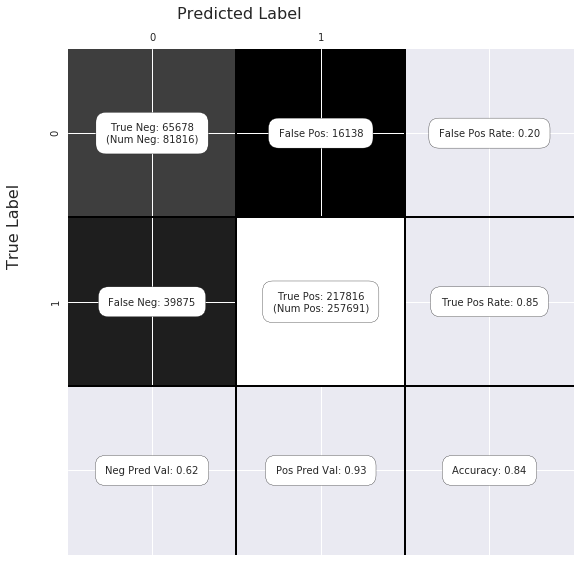

In [42]:
show_confusion_matrix(cm1)  

In [43]:
clf1.fit(X_train_bi, y_tr)

LogisticRegression(C=1.0,
          class_weight={0: 2.0806619256688017, 1: 0.65816158783872858},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [44]:
pred1_bi = clf1.predict(X_test_bi)

In [45]:
score1_bi = clf1.score(X_test_bi, y_te)

In [47]:
cm1_bi = confusion_matrix(y_te, pred1_bi)

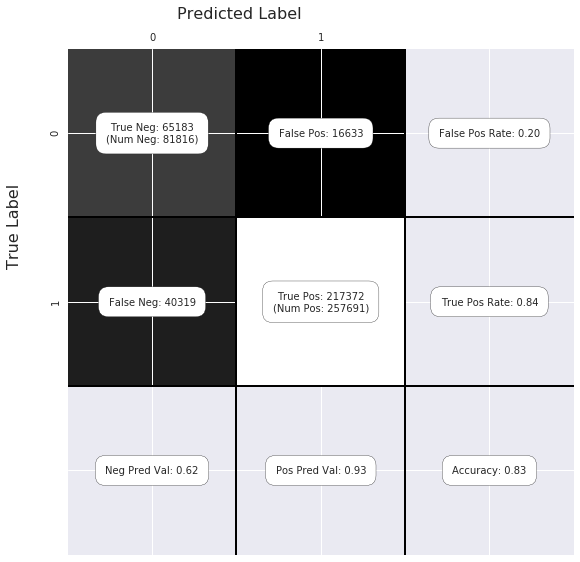

In [48]:
show_confusion_matrix(cm1_bi)

# SGD

In [49]:
clf2 = SGDClassifier(max_iter=5, loss='log')

In [50]:
clf2.fit(X_train, y_tr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [51]:
pred2 = clf2.predict(X_test)

In [52]:
cm2 = confusion_matrix(y_te, pred2)

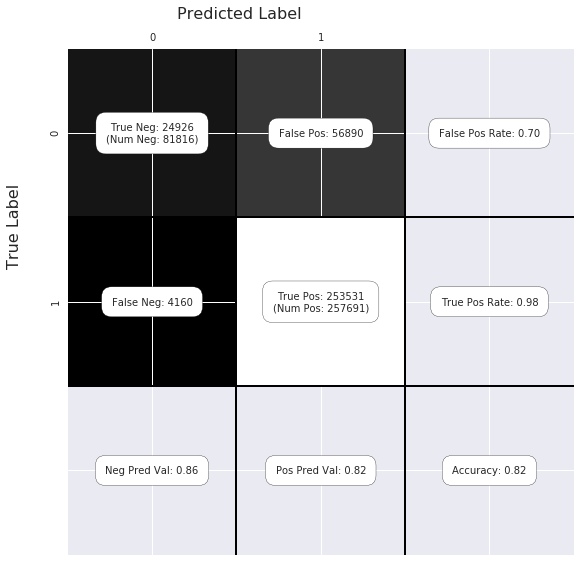

In [53]:
show_confusion_matrix(cm2)

In [54]:
clf2.fit(X_train_bi, y_tr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [55]:
pred2_bi = clf2.predict(X_test_bi)

In [56]:
cm2_bi = confusion_matrix(y_te, pred2_bi)

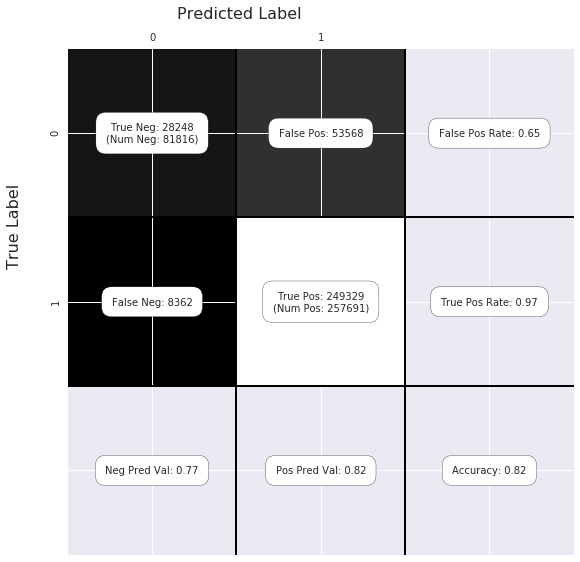

In [57]:
show_confusion_matrix(cm2_bi)